In [1]:
from message.notify_me import notify

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark
import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import Evaluator, RegressionEvaluator
from pyspark.ml.pipeline import Estimator, Model
from pyspark import keyword_only  
from pyspark.ml.param.shared import *
from pyspark.ml.util import *
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import rand
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.util import Saveable
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 1.5.3
PySpark version: 3.5.0


In [3]:
## Set up data columns name
COL_USER = "user_id"
COL_ITEM = "item_id"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "timestamp"

In [5]:
spark = SparkSession.builder\
                    .appName("Recommend")\
                    .config("spark.driver.memory", "10g") \
                    .config("spark.executor.cores", "4")  \
                    .getOrCreate()
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint')

24/01/10 14:55:51 WARN Utils: Your hostname, QuangHieu resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface wlp1s0)
24/01/10 14:55:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/10 14:55:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/10 14:55:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/10 14:55:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/01/10 14:55:53 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [6]:
df = spark.read.csv('./data/cleaned_ratings.csv', header=True, inferSchema=True)
df_1 = df['user_id','ISBN', 'rating']
indexer = StringIndexer(inputCol="ISBN", outputCol="item_id")
data = indexer.fit(df_1).transform(df_1)
data.show(5)

24/01/10 14:56:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+-------+----------+------+-------+
|user_id|      ISBN|rating|item_id|
+-------+----------+------+-------+
|   2276|0020960808|    10|11965.0|
|   2276|0030632366|     9| 4638.0|
|   2276|0061030643|     8| 1011.0|
|   2276|0061098353|     8|13612.0|
|   2276|0061099155|     9| 2576.0|
+-------+----------+------+-------+
only showing top 5 rows



In [11]:
pd_data = data.toPandas()
type(pd_data)
pd_data.to_csv('./data/rating_indexed.csv')

24/01/10 14:58:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [16]:
data.count()

87812

In [17]:
data.select("user_id").distinct().count()

251

In [18]:
data.select("item_id").distinct().count()

64225

In [19]:
## Split data to 80-20
data = data.orderBy(rand(seed=42))
dfs_train, dfs_test = spark_random_split(data, ratio=0.75, seed=42)

In [20]:
dfs_train.select("item_id").distinct().count()

50733

## Tuning based on RMSE

In [32]:
param_dict = {
    "rank": [15, 20, 25, 30, 35],
    "regParam": [0.01, 0.05, 0.1, 0.5, 1]
}


In [33]:
param_grid = generate_param_grid(param_dict)
grid = list()
for g in param_grid:
    grid.append(list(g.values()))
print(grid)

[[15, 0.01], [15, 0.05], [15, 0.1], [15, 0.5], [15, 1], [20, 0.01], [20, 0.05], [20, 0.1], [20, 0.5], [20, 1], [25, 0.01], [25, 0.05], [25, 0.1], [25, 0.5], [25, 1], [30, 0.01], [30, 0.05], [30, 0.1], [30, 0.5], [30, 1], [35, 0.01], [35, 0.05], [35, 0.1], [35, 0.5], [35, 1]]


In [34]:
dfs_train.cache()
dfs_test.cache()
rmse_score_train = []
rmse_score_test = []
try:
    for g in grid:
        als = ALS(        
            userCol=COL_USER, 
            itemCol=COL_ITEM, 
            ratingCol=COL_RATING,
            maxIter = 25,
            #nonnegative=True,
            coldStartStrategy="drop",
            #**g
        )
        
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
        # tuning model using ParamGridBuilder
        param_grid_ = ParamGridBuilder()\
                 .addGrid(als.rank, [g[0]])\
                 .addGrid(als.regParam, [g[1]])\
                 .build()
        
        #crossval = CrossValidator(estimator=als,
        #                      estimatorParamMaps=param_grid_,
        #                      evaluator=evaluator,
        #                      numFolds=3, seed=12)
        
        #model = crossval.fit(dfs_train)
        #best_model = model.bestModel
        tvs = TrainValidationSplit(estimator=als,
                                  estimatorParamMaps=param_grid_,
                                  evaluator=evaluator,
                                  trainRatio=0.8)
                                    # 80% train data will be used to train and 20% to validate
        
        best_model = tvs.fit(dfs_train)
        #dfs_pred = model.transform(dfs_test).drop(COL_RATING)
        dfs_pred_train = best_model.transform(dfs_train)
        rmse_train = evaluator.evaluate(dfs_pred_train)
        
        dfs_pred_test = best_model.transform(dfs_test)
        rmse_test = evaluator.evaluate(dfs_pred_test)
            
        rmse_score_train.append(rmse_train)
        rmse_score_test.append(rmse_test)
        
    rmse_score_train = [float('%.5f' % x) for x in rmse_score_train]
    rmse_score_test = [float('%.5f' % x) for x in rmse_score_test]
    
    rmse_score_train_array = np.reshape(rmse_score_train, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
    rmse_score_test_array = np.reshape(rmse_score_test, (len(param_dict["rank"]), len(param_dict["regParam"]))) 
except:
    notify()
finally:
    notify()

In [35]:
rmse_train = pd.DataFrame(data=rmse_score_train_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))
rmse_test = pd.DataFrame(data=rmse_score_test_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

<Axes: xlabel='reg. parameter', ylabel='rank'>

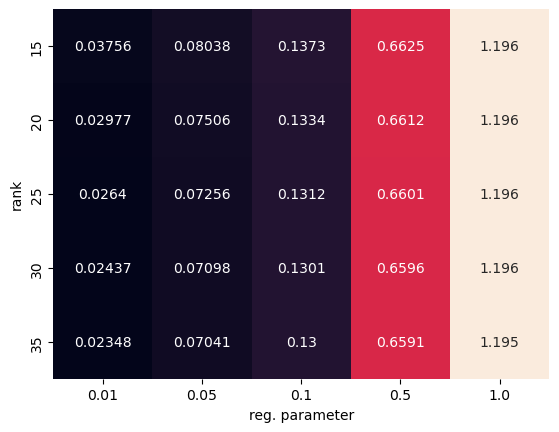

In [36]:
fig, ax = plt.subplots()
sns.heatmap(rmse_train, cbar=False, annot=True, fmt=".4g")

<Axes: xlabel='reg. parameter', ylabel='rank'>

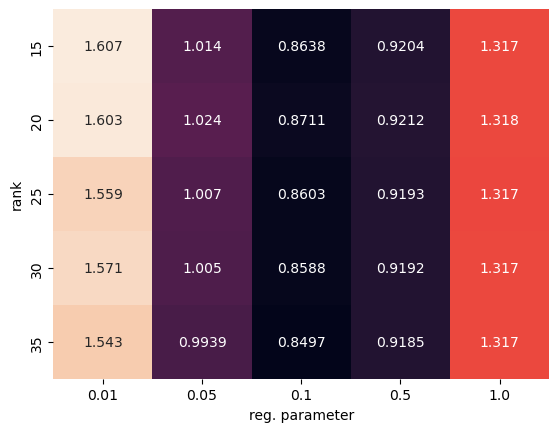

In [37]:
fig, ax = plt.subplots()
sns.heatmap(rmse_test, cbar=False, annot=True, fmt=".4g")

Model với rank = 30, regParam = 0.5, maxIter = 25

We will continue deep dive in this model using Crossvalidation

## Tuning based on Precision@K

### Split data

In [39]:
train, test = spark_random_split(data, ratio=0.75)

In [40]:
### Customized Estimator and Transformer for top k recommender based on Spark ALS

In [41]:
class ALSTopK(
    ALS,
    Estimator,
    HasInputCol,
    HasPredictionCol
):    
    rank = Param(Params._dummy(), "rank", "rank of the factorization",
                 typeConverter=TypeConverters.toInt)
    numUserBlocks = Param(Params._dummy(), "numUserBlocks", "number of user blocks",
                          typeConverter=TypeConverters.toInt)
    numItemBlocks = Param(Params._dummy(), "numItemBlocks", "number of item blocks",
                          typeConverter=TypeConverters.toInt)
    implicitPrefs = Param(Params._dummy(), "implicitPrefs", "whether to use implicit preference",
                          typeConverter=TypeConverters.toBoolean)
    alpha = Param(Params._dummy(), "alpha", "alpha for implicit preference",
                  typeConverter=TypeConverters.toFloat)
    userCol = Param(Params._dummy(), "userCol", "column name for user ids. Ids must be within " +
                    "the integer value range.", typeConverter=TypeConverters.toString)
    itemCol = Param(Params._dummy(), "itemCol", "column name for item ids. Ids must be within " +
                    "the integer value range.", typeConverter=TypeConverters.toString)
    ratingCol = Param(Params._dummy(), "ratingCol", "column name for ratings",
                      typeConverter=TypeConverters.toString)
    nonnegative = Param(Params._dummy(), "nonnegative",
                        "whether to use nonnegative constraint for least squares",
                        typeConverter=TypeConverters.toBoolean)
    intermediateStorageLevel = Param(Params._dummy(), "intermediateStorageLevel",
                                     "StorageLevel for intermediate datasets. Cannot be 'NONE'.",
                                     typeConverter=TypeConverters.toString)
    finalStorageLevel = Param(Params._dummy(), "finalStorageLevel",
                              "StorageLevel for ALS model factors.",
                              typeConverter=TypeConverters.toString)
    coldStartStrategy = Param(Params._dummy(), "coldStartStrategy", "strategy for dealing with " +
                              "unknown or new users/items at prediction time. This may be useful " +
                              "in cross-validation or production scenarios, for handling " +
                              "user/item ids the model has not seen in the training data. " +
                              "Supported values: 'nan', 'drop'.",
                              typeConverter=TypeConverters.toString)

    @keyword_only
    def __init__(
        self,
        rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
        implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None, k=10,
        ratingCol="rating", nonnegative=False, checkpointInterval=10,
        intermediateStorageLevel="MEMORY_AND_DISK",
        finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan"
    ):
        super(ALS, self).__init__()
        self._java_obj = self._new_java_obj("org.apache.spark.ml.recommendation.ALS", self.uid)
        self._setDefault(rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
                         implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item",
                         ratingCol="rating", nonnegative=False, checkpointInterval=10,
                         intermediateStorageLevel="MEMORY_AND_DISK",
                         finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan")

        kwargs = self._input_kwargs 
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        self.setParams(**kwargs)
        
        # The manually added parameter is not present in ALS Java implementation. 
        self.k = k
        
    def setRank(self, value):
        """
        Sets the value of :py:attr:`rank`.
        """
        return self._set(rank=value)

    def getRank(self):
        """
        Gets the value of rank or its default value.
        """
        return self.getOrDefault(self.rank)
    
    def setParams(self, rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10,
                  implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None,
                  ratingCol="rating", nonnegative=False, checkpointInterval=10,
                  intermediateStorageLevel="MEMORY_AND_DISK",
                  finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan"):
        """
        setParams(self, rank=10, maxIter=10, regParam=0.1, numUserBlocks=10, numItemBlocks=10, \
                 implicitPrefs=False, alpha=1.0, userCol="user", itemCol="item", seed=None, \
                 ratingCol="rating", nonnegative=False, checkpointInterval=10, \
                 intermediateStorageLevel="MEMORY_AND_DISK", \
                 finalStorageLevel="MEMORY_AND_DISK", coldStartStrategy="nan")
        Sets params for ALS.
        """
        kwargs = self._input_kwargs
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        return self._set(**kwargs)
        
    def _fit(self, dataset):
        kwargs = self._input_kwargs    
        # Exclude k as it is not a parameter for ALS.
        kwargs = {x: kwargs[x] for x in kwargs if x not in {'k'}}
        kwargs['rank'] = self.getRank()
        kwargs['regParam'] = self.getOrDefault(self.regParam)
        als = ALS(
            **kwargs
        )
        als_model = als.fit(dataset)
        
        user_col = kwargs['userCol']
        item_col = kwargs['itemCol']
        
        k = self.k
                     
        topk_model = ALSTopKModel()
        topk_model.setParams(
            als_model,
            user_col, 
            item_col, 
            k
        )
        
        return topk_model
    
    
class ALSTopKModel(
    Model,
    HasInputCol,
    HasPredictionCol,
    HasLabelCol
):    
    def setParams(self, model, userCol, itemCol, k):
        self.model = model
        self.userCol = userCol
        self.itemCol = itemCol
        self.k = k
    
    def _transform(self, dataset):
        predictionCol = self.getPredictionCol()
        labelCol = self.getLabelCol()
        
        users = dataset.select(self.userCol).distinct()
        topk_recommendation = self.model.recommendForUserSubset(users, self.k)  
        
        extract_value = F.udf((lambda x: [y[0] for y in x]), ArrayType(IntegerType()))
        topk_recommendation = topk_recommendation.withColumn(predictionCol, extract_value(F.col("recommendations")))        
        
        dataset = (
            dataset
            .groupBy(self.userCol)
            .agg(F.collect_list(F.col(self.itemCol)).alias(labelCol))
        )
            
        topk_recommendation_all = dataset.join(
            topk_recommendation, 
            on=self.userCol,
            how="outer"
        )
        
        return topk_recommendation_all.select(self.userCol, labelCol, predictionCol)

In [42]:
### Customized precision@k evaluation metric

In [43]:
# Define a custom Evaulator. Here precision@k is used.
class PrecisionAtKEvaluator(Evaluator):

    def __init__(self, predictionCol="prediction", labelCol="label", k=10):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.k = k

    def _evaluate(self, dataset):
        """
        Returns a random number. 
        Implement here the true metric
        """      
        # Drop Nulls.
        dataset = dataset.na.drop()
        metrics = RankingMetrics(dataset.select(self.predictionCol, self.labelCol).rdd)
        return metrics.precisionAt(self.k)

    def isLargerBetter(self):
        return True

In [52]:
alstopk = ALSTopK(
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    maxIter = 25,
    coldStartStrategy="drop",
    k=10
)


paramGrid = ParamGridBuilder() \
    .addGrid(alstopk.rank, [15, 20, 25, 30, 35]) \
    .addGrid(alstopk.regParam, [0.01, 0.05, 0.1, 0.5, 1]) \
    .build()

tvs = TrainValidationSplit(
    estimator=alstopk,
    estimatorParamMaps=paramGrid,
    # A regression evaluation method is used. 
    evaluator=PrecisionAtKEvaluator(),
    # 75% of the data will be used for training, 25% for validation.
    # NOTE here the splitting is random. The Spark splitting utilities (e.g. chrono splitter)
    # are therefore not available here. 
    trainRatio=0.75
)

In [58]:
# Run TrainValidationSplit, and choose the best set of parameters.
# NOTE train and valid is union because in Spark TrainValidationSplit does splitting by itself.
model_precision = tvs.fit(train.union(valid))

model_precision.getEstimatorParamMaps()

[{Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15,
  Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15,
  Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15,
  Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15,
  Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.5},
 {Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15,
  Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 1.0},
 {Param(parent='ALSTopK_c9e36cf13

In [59]:
def best_param(model, is_larger_better=True):
    if is_larger_better:
        best_metric = max(model.validationMetrics)
    else:
        best_metric = min(model.validationMetrics)
        
    parameters = model.getEstimatorParamMaps()[model.validationMetrics.index(best_metric)]
     
    return list(parameters.values())

In [60]:
params = best_param(model_precision)

In [61]:
params

[35, 0.01]

In [62]:
model_precision.bestModel.transform(valid).limit(5).show()

for idx, item in enumerate(model_precision.getEstimatorParamMaps()):
    print('Run {}:'.format(idx))
    print('\tValidation Metric: {}'.format(model_precision.validationMetrics[idx]))
    for key, value in item.items():
        print('\t{0}: {1}'.format(repr(key), value))

+-------+--------------------+--------------------+
|user_id|               label|          prediction|
+-------+--------------------+--------------------+
|   2276|[13612.0, 20559.0...|[638, 1854, 333, ...|
|   3757|[20330.0, 61158.0...|[63985, 63106, 61...|
|   4017|[5114.0, 2701.0, ...|[36, 1, 1168, 113...|
|   4385|[21366.0, 21629.0...|[9, 7806, 3456, 6...|
|   6242|[147.0, 5069.0, 1...|[123, 537, 2830, ...|
+-------+--------------------+--------------------+

Run 0:
	Validation Metric: 0.03266932270916334
	Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15
	Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.01
Run 1:
	Validation Metric: 0.055776892430278883
	Param(parent='ALSTopK_c9e36cf132cd', name='rank', doc='rank of the factorization'): 15
	Param(parent='ALSTopK_c9e36cf132cd', name='regParam', doc='regularization parameter (>= 0).'): 0.05
Run 2:
	Validation Metric: 0.051792828685259015
	Param(par

Final model with rank = 35, regParam = 0.01, maxIter = 25, coldStartStrategy="drop"


In [21]:
als = ALS(
    maxIter=25, 
    rank=35,
    regParam=0.01, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model_final = als.fit(dfs_train)
pred = model_final.transform(dfs_test)

In [22]:
pred.show(10)

+-------+----------+------+-------+----------+
|user_id|      ISBN|rating|item_id|prediction|
+-------+----------+------+-------+----------+
|  11676|0425098532|     8| 7340.0|  8.004161|
|  11676|050552502X|     7| 8389.0|  6.982695|
|  11676|0571215165|     8|36224.0|  8.004161|
|  16634|0441294677|     7| 1959.0|  6.984865|
|  16795|0590251651|     7|36538.0| 7.0058756|
|  17950|0553255355|     5|35071.0| 5.0054045|
|  25409|0525946233|    10| 1342.0|   9.99942|
|  31826|039914501X|    10| 7253.0|  9.980966|
|  31826|0671004530|    10|  463.0|  9.936592|
|  31826|0684814994|    10|  471.0|  9.933265|
+-------+----------+------+-------+----------+
only showing top 10 rows



In [23]:
model_final.save("./model/model_2")